In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import solve_ivp

# Network parameters
n = 100  # Number of nodes
m = 2   # Number of edges to attach from a new node to existing nodes
p = 0.1
G = nx.barabasi_albert_graph(n, m)
#G = nx.erdos_renyi_graph(n, p)

# Time span for the simulation
t_span = (0, 10)
t_eval = np.linspace(*t_span, 10)

# Monte Carlo parameters
num_simulations = 100
beta_mean = 0.1
beta_std = 0.2
gamma_mean = 0.5
gamma_std = 0.1

# Initial conditions
S0 = np.ones(n) - 0.4
I0 = np.zeros(n); I0[0] = 0.4 
R0 = np.zeros(n)


# Function to run a single simulation
def SIRCON_MC(G, beta, gamma, S0, I0, R0, t_span, t_eval):
    def sir_on_network(t, y, G, beta, gamma):
        n = len(G.nodes)
        S, I, R = np.split(y, 3)
        dSdt = np.zeros(n)
        dIdt = np.zeros(n)
        dRdt = np.zeros(n)
        
        for node in range(n):
            infected_neighbors = sum(I[neighbor] for neighbor in G.neighbors(node))
            dSdt[node] = -beta * S[node] * infected_neighbors 
            dIdt[node] = beta * S[node] * infected_neighbors - gamma * I[node]
            dRdt[node] = gamma * I[node]
            
        return np.concatenate([dSdt, dIdt, dRdt])

    y0 = np.concatenate([S0, I0, R0])
    solution = solve_ivp(sir_on_network, t_span, y0, args=(G, beta, gamma), t_eval=t_eval, method='RK45')
    return solution.y

# # Running Monte Carlo simulations
results = SIRCON_MC(G, beta_mean, gamma_mean, S0, I0, R0, t_span, t_eval)
    
    
# node_index = 1
S, I, R = np.split(results, 3)
# plt.plot(t_eval, I[node_index], label='Infected', color='orange')
# plt.plot(t_eval, S[node_index], label='Susceptible', color='blue')
# plt.plot(t_eval, R[node_index], label='Recovered', color='green')
# plt.xlabel('Time')
# plt.ylabel('Fraction of Population')
# plt.legend()
# plt.title(f'Disease Dynamics in Node {node_index}')
# plt.show()

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def run_sir_with_sems(G, S0, I0, R0, t_span, t_eval):
    sim_counts = [100, 500, 1000, 5000, 10000]
    sim_counts1 = [1000, 10000, 100000, 1000000, 10000000]  # Adjust this list as needed
    SEMs = {'s': [], 'i': [], 'r': []}

    for count in sim_counts:
        beta = 0.1
        gamma = 0.1
        results = SIRCON_MC(G, beta, gamma, S0, I0, R0, t_span, t_eval)
        S, I, R = np.split(results, 3)

        SEM_s = np.std(S, axis=1) / np.sqrt(count)
        SEM_i = np.std(I, axis=1) / np.sqrt(count)
        SEM_r = np.std(R, axis=1) / np.sqrt(count)

        # Collect the last time point SEMs for each count
        SEMs['s'].append(SEM_s[-1])
        SEMs['i'].append(SEM_i[-1])
        SEMs['r'].append(SEM_r[-1])

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(sim_counts1, SEMs['s'], label='SEM of Susceptible', marker='o')
    plt.plot(sim_counts1, SEMs['i'], label='SEM of Infected', marker='x')
    plt.plot(sim_counts1, SEMs['r'], label='SEM of Recovered', marker='*')
    plt.xlabel('Number of Simulations Run (Sample Size)')
    plt.ylabel('SEM')
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.savefig('C:/Users/abbau/Downloads/ECon.pdf', format='pdf',bbox_inches="tight")
    plt.show()

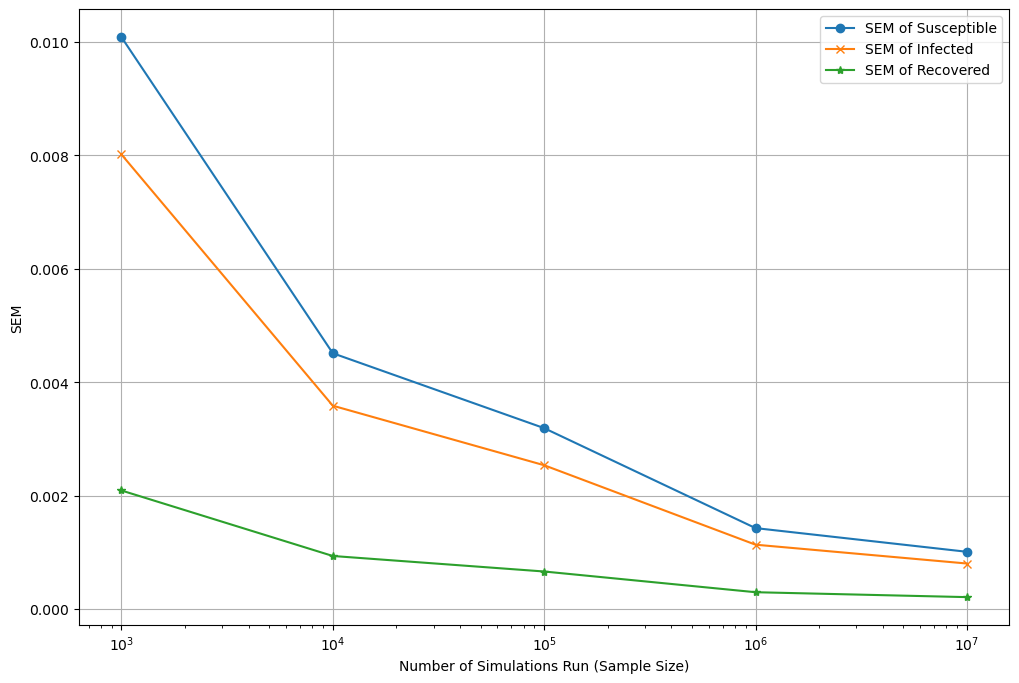

In [45]:
run_sir_with_sems(G, S0, I0, R0, t_span, t_eval)

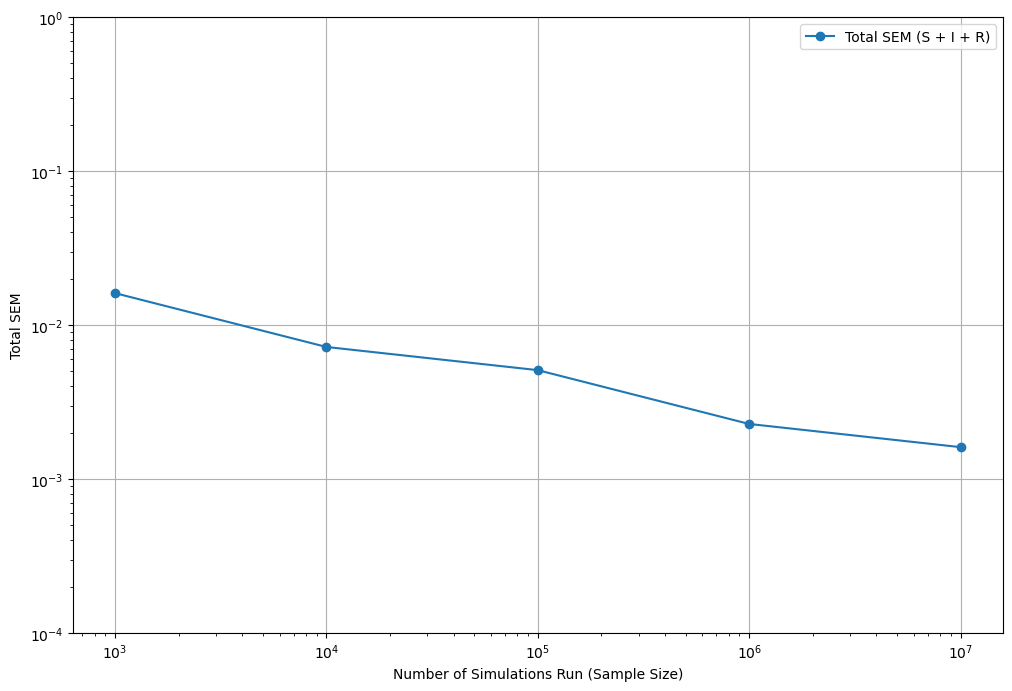

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def run_sir_with_sems(G, S0, I0, R0, t_span, t_eval):
    sim_counts = [1000, 10000, 100000, 1000000, 10000000]  # Adjust this list as needed
    SEMs = {'s': [], 'i': [], 'r': []}

    for count in sim_counts:
        beta = 0.1
        gamma = 0.1
        results = SIRCON_MC(G, beta, gamma, S0, I0, R0, t_span, t_eval) 
        observed_s, observed_i, observed_r = np.split(results, 3)
        SEM_s = np.std(observed_s, axis=1) / np.sqrt(count)
        SEM_i = np.std(observed_i, axis=1) / np.sqrt(count)
        SEM_r = np.std(observed_r, axis=1) / np.sqrt(count)

        # Collect the last time point SEMs for each count
        SEMs['s'].append(SEM_s[-1])
        SEMs['i'].append(SEM_i[-1])
        SEMs['r'].append(SEM_r[-1])

    # Calculate the sum of SEMs for the last time point
    SEM_total = [SEMs['s'][i] + SEMs['i'][i] + SEMs['r'][i] for i in range(len(sim_counts))]
    
    # Ensure SEM_total has no zero values
    SEM_total = [max(val, 1e-10) for val in SEM_total]

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(sim_counts, SEM_total, label='Total SEM (S + I + R)', marker='o')
    plt.xlabel('Number of Simulations Run (Sample Size)')
    plt.ylabel('Total SEM')
    plt.xscale('log')
    plt.yscale('log')

    # Adjust y-axis limits and add more y-ticks for better visualization
    plt.ylim(min(SEM_total) / 10, max(SEM_total) * 10)
    yticks = [10**i for i in range(int(np.floor(np.log10(min(SEM_total)))) - 1, int(np.ceil(np.log10(max(SEM_total)))) + 2)]
    plt.yticks(yticks)
    
    plt.legend()
    plt.grid(True)
    plt.savefig('C:/Users/abbau/Downloads/BCon.pdf', format='pdf',bbox_inches="tight")
    plt.show()

# Example of how to call the function:
run_sir_with_sems(G, S0, I0, R0, t_span, t_eval)


In [25]:
import networkx as nx

# Network parameters
n = 100  # Number of nodes
m = 2    # Number of edges to attach from a new node to existing nodes in the BA model
p = 0.1  # Probability of edge creation between any two nodes in the ER model

# Generate the two graphs
G_ba = nx.barabasi_albert_graph(n, m)
G_er = nx.erdos_renyi_graph(n, p)

# Compare number of nodes and edges
nodes_ba = G_ba.number_of_nodes()
edges_ba = G_ba.number_of_edges()
nodes_er = G_er.number_of_nodes()
edges_er = G_er.number_of_edges()

print("Barabási-Albert Graph has {} nodes and {} edges".format(nodes_ba, edges_ba))
print("Erdős-Rényi Graph has {} nodes and {} edges".format(nodes_er, edges_er))

# Check if they have the same number of nodes and edges
same_nodes = nodes_ba == nodes_er
same_edges = edges_ba == edges_er

print("Do both graphs have the same number of nodes? {}".format(same_nodes))
print("Do both graphs have the same number of edges? {}".format(same_edges))


Barabási-Albert Graph has 100 nodes and 196 edges
Erdős-Rényi Graph has 100 nodes and 486 edges
Do both graphs have the same number of nodes? True
Do both graphs have the same number of edges? False
